In [1]:
from boututils.datafile import DataFile
from boutdata.collect import collect
from boutdata.data import BoutData
import os, sys
import matplotlib
# matplotlib.use('Qt5Agg',force=True)
# matplotlib.use("TKAgg",force=True)
# matplotlib.use("widget",force=True)
import matplotlib.pyplot as plt
import xbout
import pandas as pd
import numpy as np
import pickle as pkl
import xarray as xr

from boutdata.restart import addvar
import glob
import shutil

import scipy

sys.path.append(r"/ssd_scratch/scripts/sdtools")


from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.neutral_transport import NeutralTransport
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *
from hermes3.utils import *
# from code_comparison.code_comparison import *


%load_ext autoreload
%autoreload 2

# IO

In [2]:
cs = dict()

db = CaseDB(
    case_dir = r"/ssd_scratch/hcases",
    grid_dir = r"/ssd_scratch/hcases"
    )

toload = [ 
    dict(name="example", id="1D-recycling-cvode", guard_replace = False, unnormalise = False),  
    # dict(name="swap_ee_ei", id="sc10c-swap_ee_ei", unnormalise_geom = True, use_xhermes = True, guard_replace = False),  

]

for case in toload:
    cs[case["name"]] = Load.case_1D(db.casepaths[case["id"]], guard_replace = case["guard_replace"], unnormalise = case["unnormalise"])


/ssd_scratch/scripts/.venv/lib/python3.11/site-packages/xarray/core/concat.py:527: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


Skipping unnormalisation


# Sheath_boundary_simple reconstruction

# Convergence

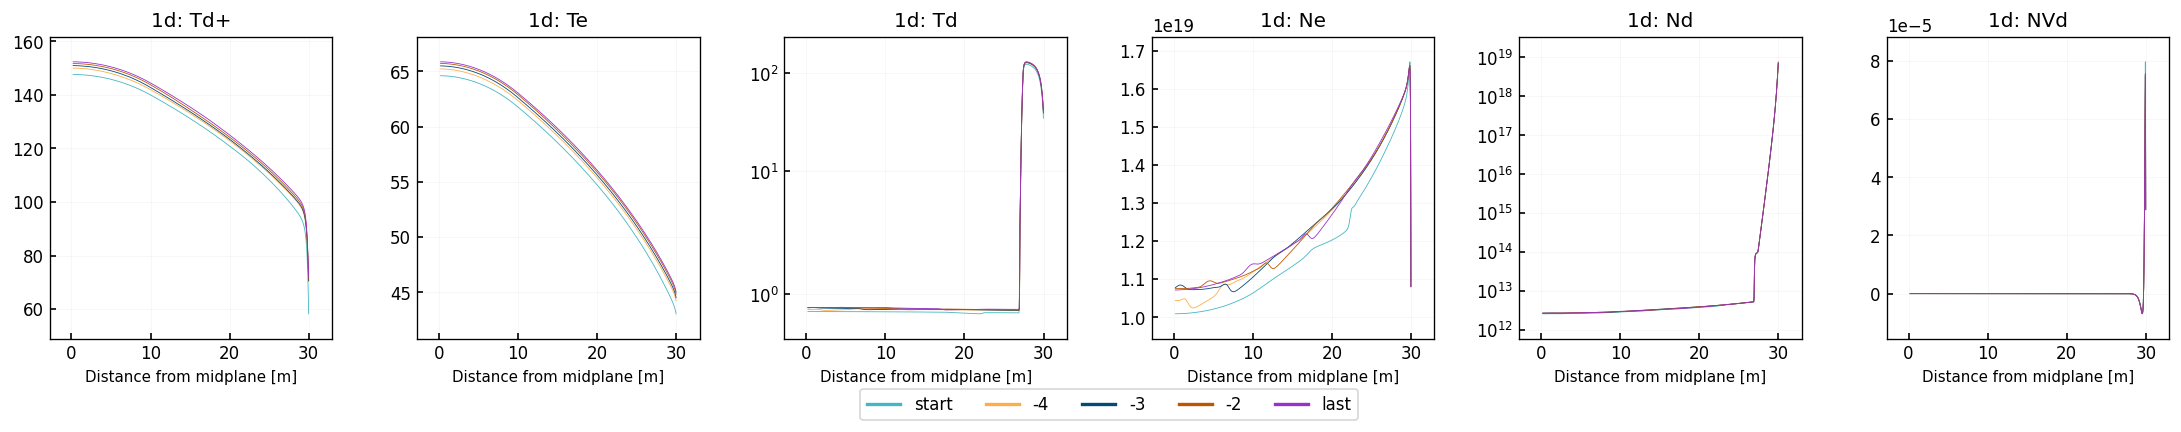

In [3]:
case = "example"

lineplot(
    {
        "start":cs[case].ds.isel(t=0),
        "-4":cs[case].ds.isel(t=-4),
        "-3":cs[case].ds.isel(t=-3),
        "-2":cs[case].ds.isel(t=-2),
        "last":cs[case].ds.isel(t=-1),

    },
    clean_guards = True,
    params = ["Td+", "Te", "Td", "Ne", "Nd", "NVd"],
    regions = ["1d"],
    lw = 0.5,
    markersize = 0
    # xlims=(8,10.3)
)

# Reconstruction

## Functions

In [4]:
ds  = cs["example"].ds

mp = constants("mass_p")
me = constants("mass_e")
qe = constants("q_e")

gamma_e = ds.options["sheath_boundary_simple"]["gamma_e"]
gamma_i = ds.options["sheath_boundary_simple"]["gamma_i"]

In [5]:
def limitFree(fm, fc):
    #  Limited free gradient of log of a quantity
    #  This ensures that the guard cell values remain positive
    #  while also ensuring that the quantity never increases
    # 
    #   fm  fc | fp
    #          ^ boundary
    # 
    #  exp( 2*log(fc) - log(fm) )
    # 

    if fm < fc:
        out =  fc    # Neumann
        
    if fm < 1e-10:
        out =  fc
    
    else:
        out =  fc**2 / fm

    return out.values

## Guard cell

In [6]:
# NOTE: ASSUMING OUTER GUARD CELLS HAVE BEEN REMOVED
ds = cs["example"].ds.isel(t=-1)
previous = ds.isel(pos=-3)
last = ds.isel(pos=-2)
guard = ds.isel(pos=-1)

ne_guard = limitFree(previous["Ne"], last["Ne"])
ti_guard = limitFree(previous["Td+"], last["Td+"])
te_guard = limitFree(previous["Te"], last["Te"])
pi_guard = limitFree(previous["Pd+"], last["Pd+"])

print(f"Ni_guard = {ne_guard:.6f}")
print(f"Ti_guard = {ti_guard:.6f}")
print(f"Pi_guard = {pi_guard:.6f}")

Ni_guard = 0.613505
Ti_guard = 0.849143
Pi_guard = 0.520954


- Ni_guard, Ti_guard, Pi_guard are correct
- Visheath is correct
- cisqsheath is correct

## Sheath

In [7]:
def get_sheath(param):
    return ((last[param] + guard[param]) / 2).values

tesheath = get_sheath("Te")
tisheath = get_sheath("Td+")
visheath = get_sheath("Vd+")
nisheath = get_sheath("Nd+")
nesheath = get_sheath("Ne")
nvisheath = get_sheath("NVd+")
dasheath = get_sheath("da")
dvsheath = get_sheath("dv")

sheath_ion_polytropic = 1
Zi = 1
AA = 2
Mi = AA

cisqsheath =  (sheath_ion_polytropic * tisheath + Zi * tesheath) / Mi

NVi_guard_calc = 2 * AA * nisheath * visheath - last["NVd+"].values


print(f"visheath = {visheath:.6f}")
print(f"nisheath = {nisheath:.6f}")
print(f"Vi_guard = {guard['Vd+']:.6f}")
print(f"nvisheath = {nvisheath:.6f}")
print(f"cisqsheath = {cisqsheath:.6f}")
print(f"NVi_guard_code = {guard['NVd+']:.6f}")
print(f"NVi_guard_calc = {NVi_guard_calc:.6f}")

visheath = 0.821373
nisheath = 0.673374
Vi_guard = 0.911569
nvisheath = 0.000000
cisqsheath = 0.674653
NVi_guard_code = -1.072260
NVi_guard_calc = 1.140103


In [8]:
mp = 1

# Ion flow speed
cisheath = cisqsheath**2

# Parallel heat flux in W/m^2.
# Note: Corrected for 5/2Pe convective thermal flux, and small electron kinetic energy flux
# so gamma_e is the total *energy* flux coefficient.
# q_e = ((gamma_e - 2.5) * qe * tesheath - 0.5 * me * vsheath**2) * nesheath * vsheath
# q_i = gamma_i * qe * tisheath * nesheath * vsheath

# hfe = q_e * dasheath
# hfi = q_i * dasheath
pf = visheath * nesheath * dasheath

# ds["hfe_sheath"] = hfe
# ds["hfd+_sheath"] = hfi
ds["pfd+_sheath"] = pf

# ds["hfe_sheath"].attrs.update(standard_name = "heat flux", units = "W", source = "xHermes", long_name = "sheath heat flux")
# ds["hfd+_sheath"].attrs.update(standard_name = "heat flux", units = "W", source = "xHermes", long_name = "sheath heat flux")
ds["Sd+_sheath"].attrs.update(standard_name = "particle flux", units = "s^-1", source = "xHermes", long_name = "sheath particle flux")

# (nesheath * vsheath * mp * AA).plot()
# (ds["NVd+"].isel(pos = -2)).plot()
# pf.plot()
# (nvsheath * dasheath).plot()

# Balance

IZ = 3.329344e+06
REC = -2.455165e+02
Recycle = 3.328810e+06
Recycle error = -8.689450e-05


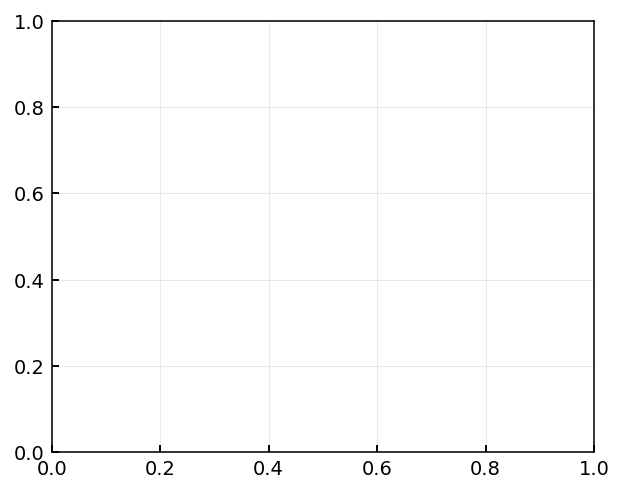

In [13]:


last = ds.isel(pos = -2)
dom = ds.isel(pos = slice(1,-1))

pf_iz = (dom["Sd+_iz"] * dom["dv"]).sum("pos")
pf_rec = (dom["Sd+_rec"] * dom["dv"]).sum("pos")
pf_recycle = (dom["Sd_target_recycle"] * dom["dv"]).sum("pos")
pf_error = (pf_recycle - (pf_iz + pf_rec)) / pf_recycle


print(f"IZ = {pf_iz:.6e}")
print(f"REC = {pf_rec:.6e}")
print(f"Recycle = {pf_recycle:.6e}")
print(f"Recycle error = {pf_error:6e}")

fig, ax = plt.subplots()

# pf_iz.plot(label = "iz")
# pf_recycle.plot(label = "recycle")
# ds["pfd+_sheath"].plot(label = "ions out")

# ax.legend()


Ni_guard = 0.613505
Ti_guard = 0.849143
Pi_guard = 0.520954

In [21]:
ne_guard[-1]

4.960652481661945e+18

In [8]:
ds["pfd+_sheath"].values

array(0.)

In [12]:
ds.dims

Frozen({'pos': 402, 't': 11})

In [6]:
ds["Ne"][-2] = (ds["Ne"][-2] + ds["Ne"][-3])/2

In [8]:
for param in ds.data_vars:
    if "pos" in ds[param].dims:
        ds[param][-2] = (ds[param][-2] + ds[param][-3])/2

In [15]:
ds = cs["noneut"].ds

# Guard replace to get position at boundaries
newpos = ds["pos"].values
attrs = ds["pos"].attrs
newpos[-2] = (newpos[-3] + newpos[-2])/2
newpos[1] = (newpos[1] + newpos[2])/2 

ds.assign_coords(pos = newpos)
ds["pos"].attrs.update(attrs)


In [4]:
cs.keys()

dict_keys(['noneut'])